# CatBoost with Optuna Hyperparameter Tuning


In [4]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Configuration
# Always anchor OUTPUT_DIR to repo root's ML/outputs/01_Catboost
_cwd = Path.cwd()
# Heuristic: repo root is the nearest ancestor that contains an 'ML' folder
c = _cwd
repo_root = None
for _ in range(5):
    if (c / 'ML').exists() and (c / 'ML').is_dir():
        repo_root = c
        break
    if c.parent == c:
        break
    c = c.parent
if repo_root is None:
    # Fallback: if we're in ML/, use its parent; else use current dir
    repo_root = _cwd.parent if _cwd.name == 'ML' else _cwd
_out_dir = (repo_root / 'ML' / 'outputs' / '01_Catboost').resolve()
# Normalize any accidental double 'ML/ML' segment just in case
_out_str = str(_out_dir)
_double = os.sep + 'ML' + os.sep + 'ML' + os.sep
_single = os.sep + 'ML' + os.sep
if _double in _out_str:
    _out_str = _out_str.replace(_double, _single)
OUTPUT_DIR = _out_str
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
print(f'OUTPUT_DIR: {OUTPUT_DIR}')

# Light blue ↔ white colormap for confusion matrices
LIGHT_CM = LinearSegmentedColormap.from_list(
    'white_to_lightblue', ['#ffffff', '#e6f0ff', '#cfe0ff']
)
# Optuna trials
N_TRIALS = 50

OUTPUT_DIR: C:\Users\Playdata\OneDrive\Desktop\SKN19-mini-1Team\ML\outputs\01_Catboost


In [5]:
# Prefer the new catboost-friendly dataset; fall back if absent
DATA_PATH = '../data/training/final/travel_insight_pruned.csv'
if not os.path.exists(DATA_PATH):
    DATA_PATH = '../data/training/final/travel_insight_pruned.csv'
travel = pd.read_csv(DATA_PATH)
print(f'Data loaded: {DATA_PATH}')

Data loaded: ../data/training/final/travel_insight_pruned.csv


In [6]:
# 'SUCCESS_SCORE'를 기반으로 새로운 이진 타겟 변수 'IS_FAILED_TRIP' 생성
# 35점 미만일 경우 '실패한 여행' (1)으로 간주
travel['IS_FAILED_TRIP'] = (travel['SUCCESS_SCORE'] < 35).astype(int)

In [7]:
BINARY_CLASSIFICATION_TARGET = 'IS_FAILED_TRIP'

BINARY_CLASSIFICATION_FEATURES = [
    'TRIP_DAYS',
    'MOVE_CNT',
    'activity_payment_sum',
    'activity_history_rows',
    'payment_persona',
    'GENDER',
    'AGE_GRP',
    'HOUSE_INCOME',
    'TRAVEL_MOTIVE_1',
    'TRAVEL_STATUS_ACCOMPANY',
    'TRAVEL_COMPANIONS_NUM',
    'RESIDENCE_SGG_CD',
    'move_cnt_per_day',
    'activity_payment_sum_per_day',
    'activity_history_rows_per_day'
]

In [8]:
# 데이터 선언
X = travel[BINARY_CLASSIFICATION_FEATURES]
y = travel[BINARY_CLASSIFICATION_TARGET]

In [9]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3
)

# Log class distribution (no auto class weighting)
from collections import Counter
cnt = Counter(y_train)
neg, pos = int(cnt.get(0, 0)), int(cnt.get(1, 0))
total = neg + pos if (neg + pos) else 1
print(f'Train class distribution -> 0: {neg}, 1: {pos} (pos_ratio={pos/total:.3f})')


Train class distribution -> 0: 3181, 1: 851 (pos_ratio=0.211)


In [ ]:

import pandas as pd
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
import numpy as np
import optuna

# ---- 0) 안전 복사 & 타겟 확인 ----
X_train = X_train.copy()
y_train = y_train.copy()

# y가 문자열/불리언이면 0/1로 바꿔둡니다.
if y_train.dtype == 'bool':
    y_train = y_train.astype(int)
elif y_train.dtype == 'object':
    # 예: {'ham','spam'} 같은 라벨이면 맵핑
    uniq = sorted(y_train.unique().tolist())
    mapping = {v:i for i, v in enumerate(uniq)}
    y_train = y_train.map(mapping)

# ---- 1) 숫자형으로 강제 변환 가능한 object 컬럼은 숫자로, 아니면 범주형으로 ----
obj_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_coerced, cat_auto = [], []

for c in obj_cols:
    # 숫자로 바꿨을 때 95% 이상 유효하면 숫자로 간주
    coerced = pd.to_numeric(X_train[c], errors='coerce')
    if coerced.notna().mean() >= 0.95:
        X_train[c] = coerced
        num_coerced.append(c)
    else:
        # 문자열 그대로 두고(또는 category로 캐스팅) 범주형으로 사용
        X_train[c] = X_train[c].astype(str)
        cat_auto.append(c)

# 기존에 지정했던 범주형 컬럼이 있으면 합치기
manual_cat = ["TRAVEL_SEASON", "activity_type_catboost"]
manual_cat = [c for c in manual_cat if c in X_train.columns]
cat_cols = sorted(set(cat_auto).union(manual_cat))

print(f"[INFO] Numeric-coerced cols: {num_coerced}")
print(f"[INFO] Categorical cols used: {cat_cols}")

# ---- 2) Optuna 목적함수 (컬럼 '이름'으로 cat_features 지정) ----
N_TRIALS = 100
RANDOM_SEED = 42
N_SPLITS = 5
EARLY_STOPPING_ROUNDS = 100
    
def objective(trial):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "PRAUC",
        "depth": trial.suggest_int("depth", 1, 6),
        "iterations": trial.suggest_int("iterations", 800, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 12.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 64),
        "border_count": trial.suggest_int("border_count", 64, 254),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
        "rsm": trial.suggest_float("rsm", 0.7, 1.0),
        "random_seed": RANDOM_SEED,
        "verbose": False,
        "auto_class_weights": "Balanced",

    }
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 3.0)
    else:
        params["subsample"] = trial.suggest_float("subsample", 0.6, 1.0)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
    scores = []

    for tr_idx, va_idx in skf.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
        valid_pool = Pool(X_va, y_va, cat_features=cat_cols)

        model = CatBoostClassifier(**params)
        model.fit(
            train_pool,
            eval_set=valid_pool,
            verbose=False,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        )

        preds = model.predict_proba(valid_pool)[:, 1]
        pr_auc = average_precision_score(y_va, preds)
        scores.append(pr_auc)

    return float(np.mean(scores))

# ---- 3) 최적화 & 최종학습 ----
print("Starting hyperparameter optimization with Optuna for CatBoost...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS)

best_trial = study.best_trial
print(f"Best PR-AUC: {best_trial.value:.4f}")
print("Best Params:")
for k, v in best_trial.params.items():
    print(f"  {k}: {v}")

final_params = {
    "loss_function": "Logloss",
    "eval_metric": "PRAUC",
    "random_seed": RANDOM_SEED,
    "verbose": False,
    "auto_class_weights": "Balanced",
}
final_params.update(best_trial.params)

best_model = CatBoostClassifier(**final_params)
best_model.fit(
    Pool(X_train, y_train, cat_features=cat_cols),
    verbose=False,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
)
print("Best model trained successfully.")


[I 2025-09-28 17:41:34,766] A new study created in memory with name: no-name-7d3dc6c1-a5bc-4026-b1e8-88eb0a46bf74


[INFO] Numeric-coerced cols: []
[INFO] Categorical cols used: ['TRAVEL_STATUS_ACCOMPANY', 'payment_persona']
Starting hyperparameter optimization with Optuna for CatBoost...


[I 2025-09-28 17:41:55,077] Trial 0 finished with value: 0.3655168423050782 and parameters: {'depth': 4, 'iterations': 1674, 'learning_rate': 0.0013326922802332256, 'l2_leaf_reg': 9.826129900017849, 'min_data_in_leaf': 33, 'border_count': 192, 'bootstrap_type': 'Bayesian', 'rsm': 0.7099939910587213, 'bagging_temperature': 0.6384646168610455}. Best is trial 0 with value: 0.3655168423050782.
[I 2025-09-28 17:41:59,403] Trial 1 finished with value: 0.32243250413479296 and parameters: {'depth': 1, 'iterations': 1734, 'learning_rate': 0.04390617090686736, 'l2_leaf_reg': 7.461425706434512, 'min_data_in_leaf': 50, 'border_count': 125, 'bootstrap_type': 'Bernoulli', 'rsm': 0.9636615874552314, 'subsample': 0.6276675501148434}. Best is trial 0 with value: 0.3655168423050782.
[I 2025-09-28 17:42:11,405] Trial 2 finished with value: 0.3529533503229934 and parameters: {'depth': 4, 'iterations': 1049, 'learning_rate': 0.0031117446175650703, 'l2_leaf_reg': 3.5110497750286194, 'min_data_in_leaf': 56, 

In [ ]:
# Stratified KFold validation with per-fold metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, average_precision_score, f1_score)
print("\n=== StratifiedKFold validation (fixed threshold 0.5) ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_pr_auc, best_fold_idx = -1.0, -1
best_model_cv = None
best_threshold_cv = None
fold_metrics = []
for i, (tr_idx, va_idx) in enumerate(cv.split(X_train, y_train), start=1):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    # CatBoost needs categorical columns as string; train/test already casted
    m = CatBoostClassifier(**final_params)
    m.fit(X_tr, y_tr, cat_features=cat_cols, verbose=0)
    proba = m.predict_proba(X_va)[:,1]
    pred = (proba >= 0.5).astype(int)
    cm = confusion_matrix(y_va, pred)
    roc = roc_auc_score(y_va, proba)
    pr = average_precision_score(y_va, proba)
    rep = classification_report(y_va, pred, output_dict=True)
    prec, rec, f1 = rep['weighted avg']['precision'], rep['weighted avg']['recall'], rep['weighted avg']['f1-score']
    acc = accuracy_score(y_va, pred)
    print(f"\n----- Fold {i} -----")
    print(f'Threshold: 0.500 (fixed)')
    print('Confusion Matrix\n', cm)
    print(f'Acc: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}')
    print(f'ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}')
    fold_metrics.append({'fold': i, 'threshold': 0.5, 'acc': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc, 'pr_auc': pr})
    if pr > best_pr_auc:
        best_pr_auc, best_fold_idx = pr, i
        best_model_cv = m
        best_threshold_cv = 0.5

print(f"\nBest fold by PR-AUC: {best_fold_idx} (PR-AUC={best_pr_auc:.4f})")
# Replace global best_model with the best fold model for downstream evaluation
if best_model_cv is not None:
    best_model = best_model_cv
    tuned_threshold = float(best_threshold_cv) if best_threshold_cv is not None else None



=== StratifiedKFold validation (fixed threshold 0.5) ===

----- Fold 1 -----
Threshold: 0.500 (fixed)
Confusion Matrix
 [[560  77]
 [130  40]]
Acc: 0.7435 | Precision: 0.7126 | Recall: 0.7435 | F1: 0.7249
ROC-AUC: 0.6174 | PR-AUC: 0.3051

----- Fold 2 -----
Threshold: 0.500 (fixed)
Confusion Matrix
 [[534 102]
 [121  50]]
Acc: 0.7237 | Precision: 0.7122 | Recall: 0.7237 | F1: 0.7176
ROC-AUC: 0.6010 | PR-AUC: 0.3083

----- Fold 3 -----
Threshold: 0.500 (fixed)
Confusion Matrix
 [[555  81]
 [124  46]]
Acc: 0.7457 | Precision: 0.7214 | Recall: 0.7457 | F1: 0.7314
ROC-AUC: 0.6235 | PR-AUC: 0.3033

----- Fold 4 -----
Threshold: 0.500 (fixed)
Confusion Matrix
 [[534 102]
 [114  56]]
Acc: 0.7320 | Precision: 0.7250 | Recall: 0.7320 | F1: 0.7284
ROC-AUC: 0.6603 | PR-AUC: 0.3454

----- Fold 5 -----
Threshold: 0.500 (fixed)
Confusion Matrix
 [[544  92]
 [126  44]]
Acc: 0.7295 | Precision: 0.7089 | Recall: 0.7295 | F1: 0.7180
ROC-AUC: 0.6262 | PR-AUC: 0.3120

Best fold by PR-AUC: 4 (PR-AUC=0.345

In [ ]:
# 베스트 모델 평가 (Train/Test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score, f1_score, fbeta_score, precision_score

# Predictions at fixed 0.4 threshold (no tuned threshold)
y_proba_train_gs = best_model.predict_proba(X_train)[:,1]
y_proba_test_gs = best_model.predict_proba(X_test)[:,1]
y_pred_train_base = (y_proba_train_gs >= 0.4).astype(int)
y_pred_test_base = (y_proba_test_gs >= 0.4).astype(int)

y_pred_train_gs = y_pred_train_base
y_pred_test_gs = y_pred_test_base

# Train report
print('='*5+'Train (BestModel)'+'='*70)
print(f'Acc : {accuracy_score(y_train, y_pred_train_gs):.4f}')
print('Confusion Matrix')
print(confusion_matrix(y_train, y_pred_train_gs))
print(classification_report(y_train, y_pred_train_gs))
print(f'ROC-AUC : {roc_auc_score(y_train, y_proba_train_gs):.4f}')
print(f'PR-AUC  : {average_precision_score(y_train, y_proba_train_gs):.4f}')
# Save confusion matrix (0.4 threshold) for test set
print('='*5+'Test (BestModel)'+'='*70)
print(f'Acc : {accuracy_score(y_test, y_pred_test_gs):.4f}')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test_gs))
print(classification_report(y_test, y_pred_test_gs))
print(f'ROC-AUC : {roc_auc_score(y_test, y_proba_test_gs):.4f}')
print(f'PR-AUC  : {average_precision_score(y_test, y_proba_test_gs):.4f}')

# Save confusion matrix images
fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_base, ax=ax, cmap=LIGHT_CM)
ax.set_title('Confusion Matrix @0.5')
plt.tight_layout()
os.makedirs(OUTPUT_DIR, exist_ok=True)
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
plt.close(fig)


=====Train (BestModel)======================================================================
Acc : 0.9075
Confusion Matrix
[[2939  242]
 [ 131  720]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3181
           1       0.75      0.85      0.79       851

    accuracy                           0.91      4032
   macro avg       0.85      0.88      0.87      4032
weighted avg       0.91      0.91      0.91      4032

ROC-AUC : 0.9446
PR-AUC  : 0.8854
=====Test (BestModel)======================================================================
Acc : 0.6765
Confusion Matrix
[[1040  311]
 [ 248  129]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1351
           1       0.29      0.34      0.32       377

    accuracy                           0.68      1728
   macro avg       0.55      0.56      0.55      1728
weighted avg       0.70      0.68      0.69      1728

ROC-AUC : 0.5

In [ ]:
# True positive rows (predict=1 & true=1)
import pandas as pd

y_pred_test_series = pd.Series(y_pred_test_gs, index=X_test.index, name='predicted')
y_proba_test_series = pd.Series(y_proba_test_gs, index=X_test.index, name='predicted_proba')
tp_mask = (y_test == 1) & (y_pred_test_series == 1)
tp_df = X_test.loc[tp_mask].copy()
tp_df['actual'] = y_test.loc[tp_mask]
tp_df['predicted'] = y_pred_test_series.loc[tp_mask]
tp_df['predicted_proba'] = y_proba_test_series.loc[tp_mask]
print(f'Total true positives in test set: {tp_df.shape[0]}')
tp_out = os.path.join(OUTPUT_DIR, 'TP_traveler_catboost.csv')
tp_df.to_csv(tp_out, index=False)
print(f'Saved: {tp_out}')

Total true positives in test set: 129
Saved: /home/maroco/SKN19-mini-1Team/ML/outputs/01_Catboost/TP_traveler_catboost.csv


In [ ]:
# True negative rows (predict=0 & true=0)
import pandas as pd

y_pred_test_series = pd.Series(y_pred_test_gs, index=X_test.index, name='predicted')
y_proba_test_series = pd.Series(y_proba_test_gs, index=X_test.index, name='predicted_proba')
tn_mask = (y_test == 0) & (y_pred_test_series == 0)
tn_df = X_test.loc[tn_mask].copy()
tn_df['actual'] = y_test.loc[tn_mask]
tn_df['predicted'] = y_pred_test_series.loc[tn_mask]
tn_df['predicted_proba'] = y_proba_test_series.loc[tn_mask]
print(f'Total true negatives in test set: {tn_df.shape[0]}')
tn_out = os.path.join(OUTPUT_DIR, 'TN_traveler_catboost.csv')
tn_df.to_csv(tn_out, index=False)
print(f'Saved: {tn_out}')

Total true negatives in test set: 1040
Saved: /home/maroco/SKN19-mini-1Team/ML/outputs/01_Catboost/TN_traveler_catboost.csv


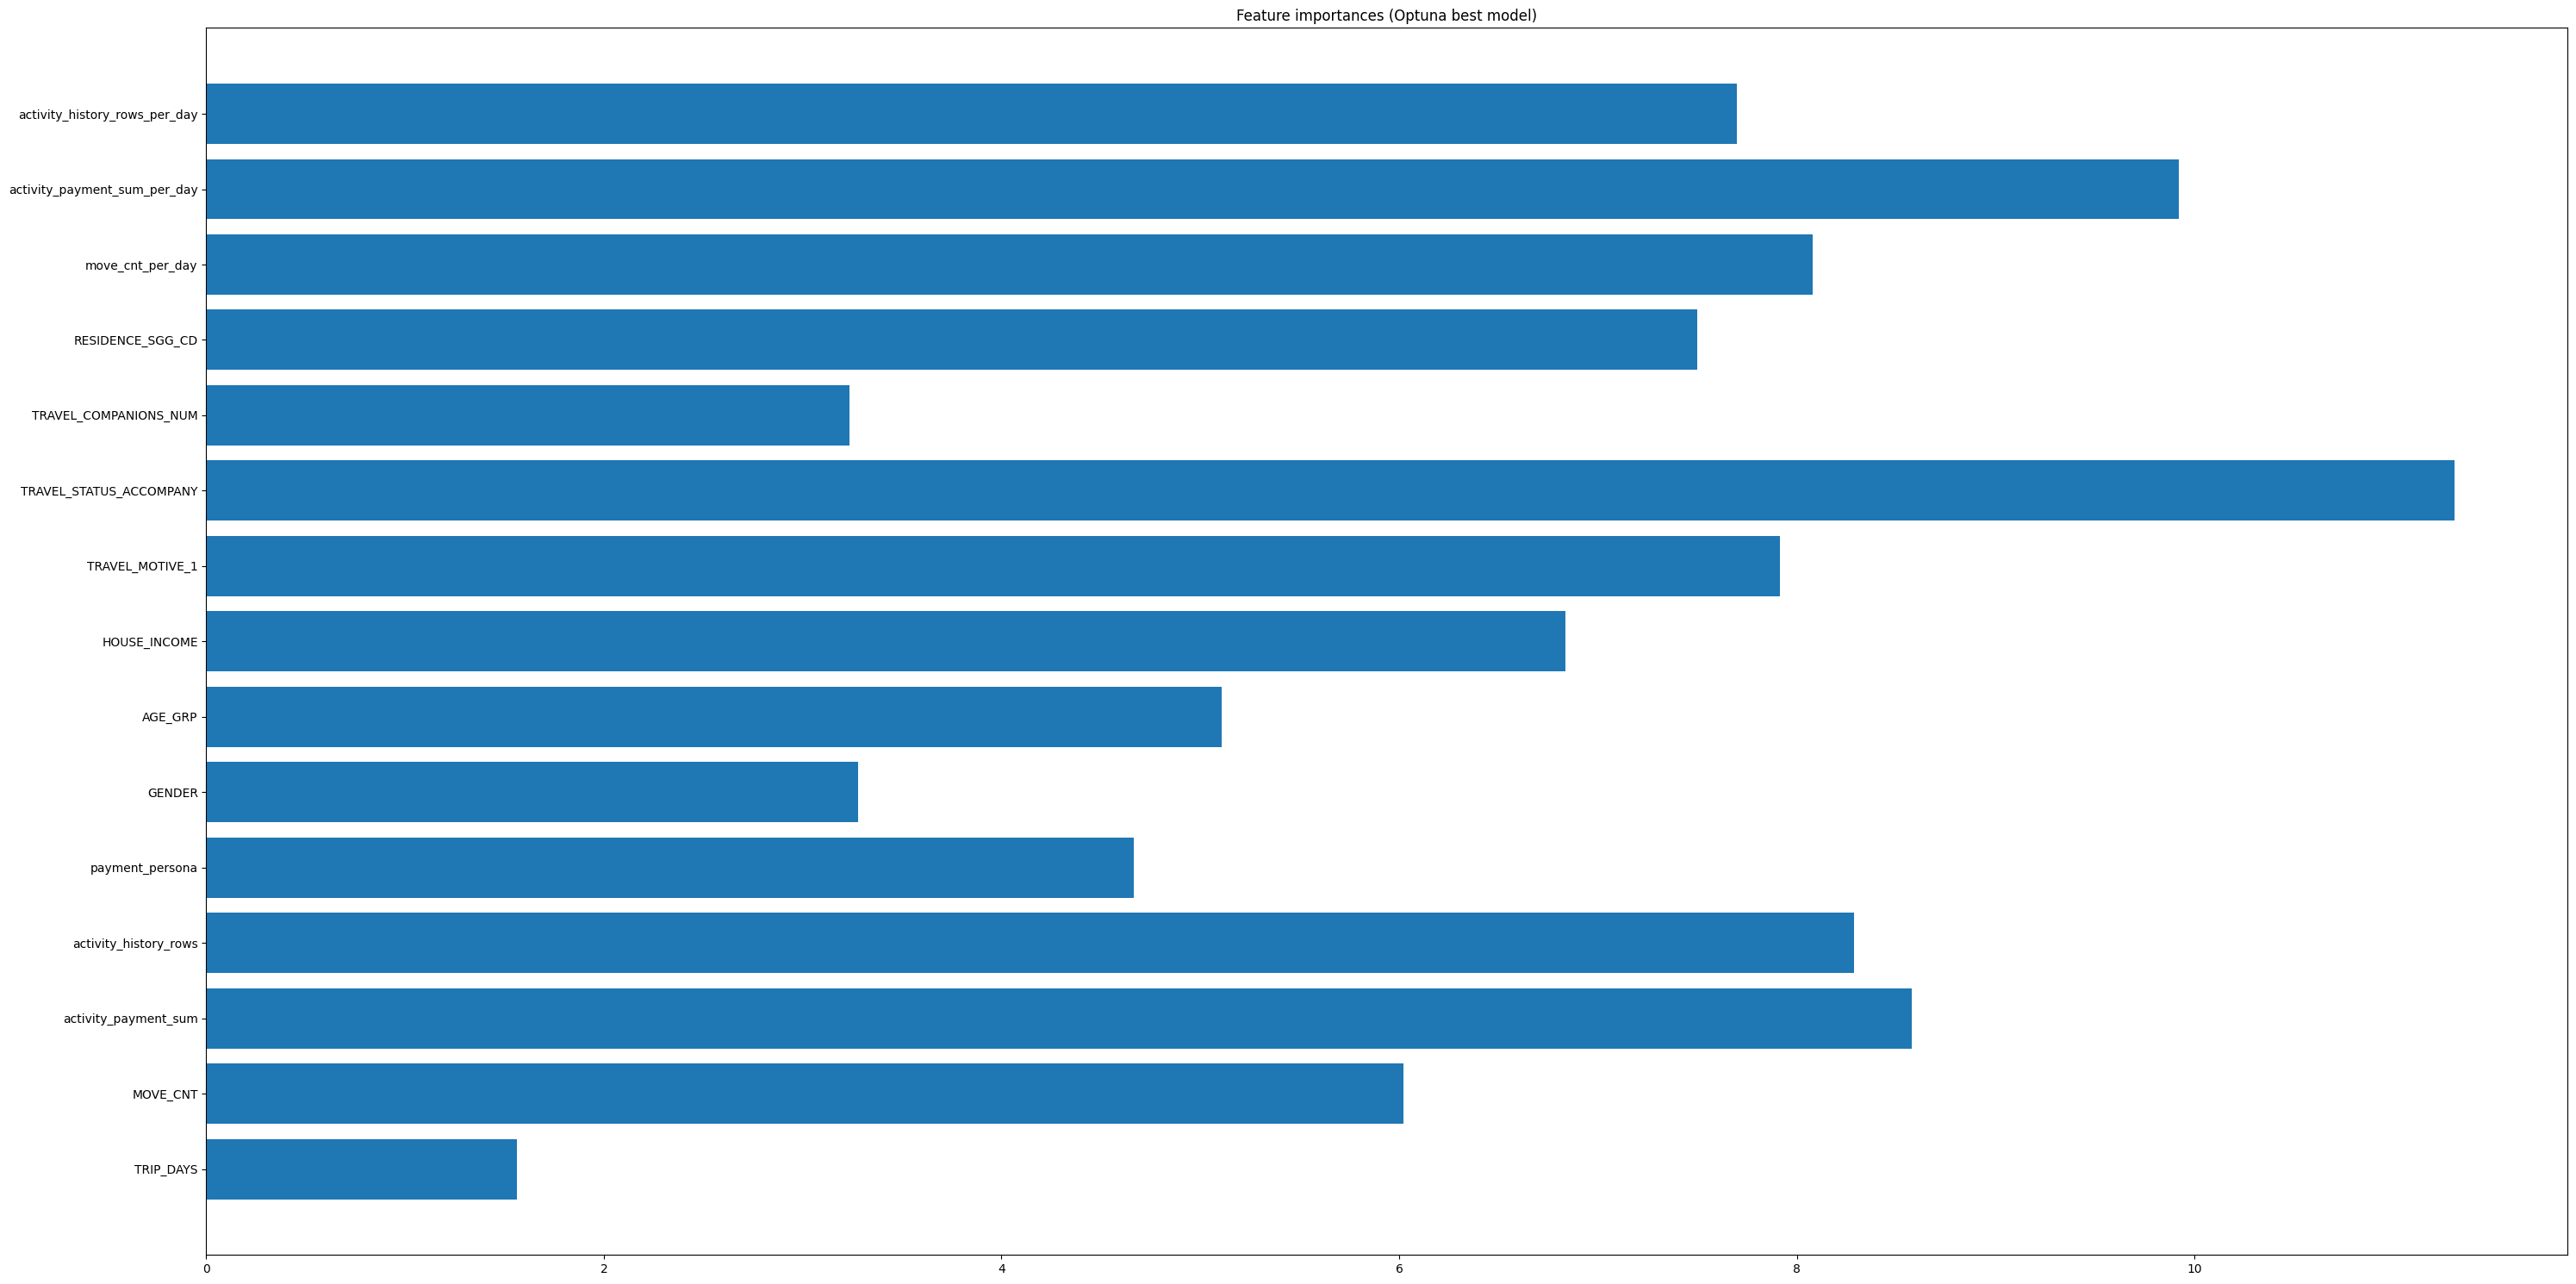

TRAVEL_STATUS_ACCOMPANY          11.310736
activity_payment_sum_per_day      9.920161
activity_payment_sum              8.580288
activity_history_rows             8.288796
move_cnt_per_day                  8.080740
TRAVEL_MOTIVE_1                   7.914943
activity_history_rows_per_day     7.697644
RESIDENCE_SGG_CD                  7.497571
HOUSE_INCOME                      6.834267
MOVE_CNT                          6.023621
AGE_GRP                           5.107830
payment_persona                   4.666134
GENDER                            3.280587
TRAVEL_COMPANIONS_NUM             3.235283
TRIP_DAYS                         1.561401
dtype: float64
Saved trained model to: /home/maroco/SKN19-mini-1Team/ML/outputs/01_Catboost/catboost_best_model.joblib
[LITE] Numeric-coerced cols: []
[LITE] Categorical cols used: []
[LITE] Test Accuracy @0.5: 0.5891
[LITE] Saved trained lite model to: /home/maroco/SKN19-mini-1Team/ML/outputs/01_Catboost/catboost_best_model_lite.joblib


In [ ]:
# 특성 중요도 (베스트 모델)
import matplotlib.pyplot as plt

plt.figure(figsize=(30,15))
plt.barh(X.columns, best_model.get_feature_importance())
plt.title('Feature importances (Optuna best model)')
plt.tight_layout()
out_path = os.path.join(OUTPUT_DIR, 'feature_importances_top.png')
plt.savefig(out_path)
plt.show()

feat_imp = best_model.get_feature_importance()
feat_names = X_train.columns
feat_imp_ser = pd.Series(feat_imp, index=feat_names)

sorted_feature_importances = feat_imp_ser.sort_values(ascending=False)
print(sorted_feature_importances)

# Save trained model with joblib next to confusion matrix (same OUTPUT_DIR)
import joblib
model_path = os.path.join(OUTPUT_DIR, 'catboost_best_model.joblib')
joblib.dump(best_model, model_path)
print(f'Saved trained model to: {model_path}')

# ----------------------------------------------------------------------------
# Lite model: train with only 4 features for minimal inference schema
# Features: TRIP_DAYS (numeric), GENDER, AGE_GRP, ACTIVITY_TYPE_CD (categorical)
# ----------------------------------------------------------------------------
LITE_FEATURES = ['TRIP_DAYS', 'GENDER', 'AGE_GRP', 'ACTIVITY_TYPE_CD']

# Build dataset for lite model
X_lite = travel[LITE_FEATURES].copy()
y_lite = y.copy()  # same target as main model

from sklearn.model_selection import train_test_split
X_train_lite, X_test_lite, y_train_lite, y_test_lite = train_test_split(
    X_lite, y_lite, random_state=42, test_size=0.3
)

# Cast object columns: numeric-coerce if >=95% valid, else as string (categorical)
obj_cols_lite = X_train_lite.select_dtypes(include=['object']).columns.tolist()
num_coerced_lite, cat_auto_lite = [], []
for c in obj_cols_lite:
    coerced = pd.to_numeric(X_train_lite[c], errors='coerce')
    if coerced.notna().mean() >= 0.95:
        X_train_lite[c] = coerced
        X_test_lite[c] = pd.to_numeric(X_test_lite[c], errors='coerce')
        num_coerced_lite.append(c)
    else:
        X_train_lite[c] = X_train_lite[c].astype(str)
        X_test_lite[c] = X_test_lite[c].astype(str)
        cat_auto_lite.append(c)
cat_cols_lite = sorted(set(cat_auto_lite))
print(f'[LITE] Numeric-coerced cols: {num_coerced_lite}')
print(f'[LITE] Categorical cols used: {cat_cols_lite}')

from catboost import Pool, CatBoostClassifier
m_lite = CatBoostClassifier(**final_params)
m_lite.fit(
    Pool(X_train_lite, y_train_lite, cat_features=cat_cols_lite),
    verbose=False,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
)
# Quick sanity metric
from sklearn.metrics import accuracy_score
pred_lite = (m_lite.predict_proba(X_test_lite)[:,1] >= 0.5).astype(int)
print(f'[LITE] Test Accuracy @0.5: {accuracy_score(y_test_lite, pred_lite):.4f}')

# Save lite model
lite_model_path = os.path.join(OUTPUT_DIR, 'catboost_best_model_lite.joblib')
joblib.dump(m_lite, lite_model_path)
print(f'[LITE] Saved trained lite model to: {lite_model_path}')